# Autoencoders

In [1]:
%matplotlib inline
import torch
import numpy as np
import autoencoder_demo_utils as utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In this demo, we'll use various types of autoencoders to project MNIST data into 2 dimensions.

In [2]:
mnist = utils.MNIST()
mnist.labeled=False

First, let's start with the regular autoencoder.

In [112]:
class RegularAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        assert emb_dim < input_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 800),
            torch.nn.ReLU(),
            torch.nn.Linear(800, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, emb_dim),
            torch.nn.ReLU()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 800),
            torch.nn.ReLU(),
            torch.nn.Linear(800, input_dim),
            torch.nn.ReLU()
        )
        
        for param in self.parameters():
            if param.ndimension() >= 2:
                torch.nn.init.xavier_uniform(param)
            else:
                param.data.zero_()
        
    def encode(self, value):
        return self.encoder(value)
    
    def decode(self, value):
        return self.decoder(value)
        
    def forward(self, value):
        return self.decode(self.encode(value))

In [113]:
autoencoder = [RegularAutoencoder(784, 2)]

In [114]:
utils.train(autoencoder, mnist, torch.nn.MSELoss(), 100, 1000, 0.001, 'regular_autoencoder')

Loaded checkpoint directly


We can see how well it can reconstruct an image:

In [115]:
mnist.labeled=True

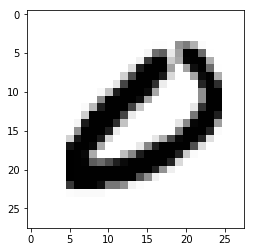

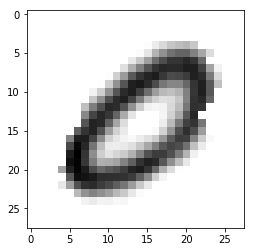

In [116]:
utils.display_reconstruction(autoencoder[0], mnist)

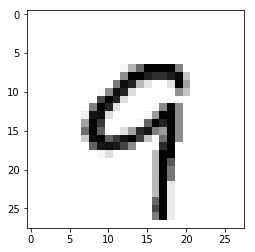

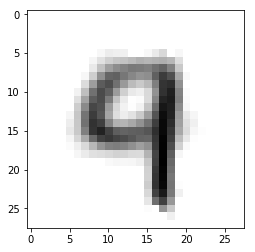

In [117]:
utils.display_reconstruction(autoencoder[0], mnist)

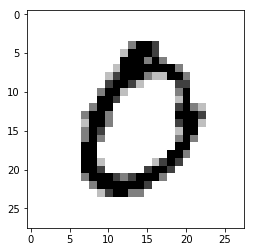

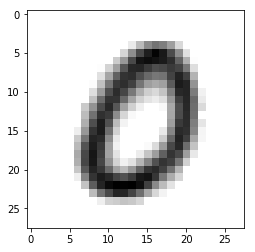

In [118]:
utils.display_reconstruction(autoencoder[0], mnist)

Makes a few mistakes, but for the most part it works.
We can also look at how the inputs are mapped onto the 2D latent space:

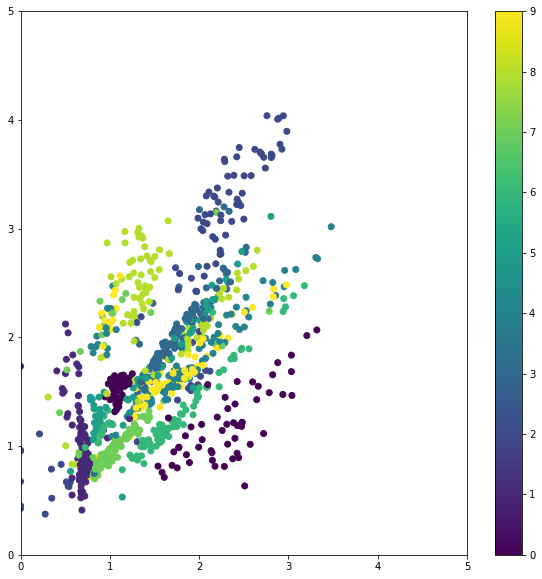

In [120]:
utils.display_encodings(autoencoder[0], mnist, [0, 5])

It's also possible to generate an artificial example by feeding in some latent value of our choosing.

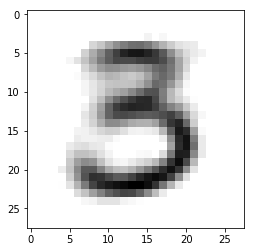

In [124]:
utils.display_decoding(autoencoder[0], mnist, torch.Tensor([2, 2.3]))

We've mentioned the issue with the sampling step in the middle for VAE's. Let's see what happens without reparameterization. I tried a few tricks to estimate a gradient for the encoder.

In [382]:
class HiddenSamplingAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, emb_dim, sample_factor, noise_mag=0.1):
        super().__init__()
        assert emb_dim < input_dim
        assert sample_factor >= emb_dim + emb_dim ** 2
        
        self.encoder_tail = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
        )
        self.encoder_mean = torch.nn.Linear(100, emb_dim)
        self.encoder_std = torch.nn.Sequential(
            torch.nn.Linear(100, emb_dim ** 2),
            torch.nn.ReLU()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, input_dim),
            torch.nn.ReLU()
        )
        
        for param in self.parameters():
            if param.ndimension() >= 2:
                torch.nn.init.xavier_uniform(param)
            else:
                param.data.zero_()
                
        self.emb_dim = emb_dim
        self.sample_factor = sample_factor
        self.noise_mag = noise_mag
        
    def encode_dist(self, value):
        tail = self.encoder_tail(value)
        mean = self.encoder_mean(tail)
        std = self.encoder_std(tail) + 0.0001
        return (mean, std)
    
    def sample(self, mean, std):
        samples = mean.data.clone()
        rands = samples.clone().normal_()
        samples += torch.matmul(std.data.view(-1, self.emb_dim, self.emb_dim),
                                rands.view(-1, self.emb_dim, 1)).view(-1, self.emb_dim)
        return torch.autograd.Variable(samples)
    
    def encode(self, value):
        return self.sample(*self.encode_dist(value))
    
    def decode(self, value):
        return self.decoder(value)
        
    def forward(self, value):
        element_dim = value.size()[1]

        value_dup = value.data.unsqueeze(dim=1)
        value_dup = value_dup.repeat(1, self.sample_factor, 1).view(-1, element_dim)
        noise = value_dup.clone().normal_() * self.noise_mag
        value_dup = torch.autograd.Variable(value_dup + noise)
        
        (mean, std) = self.encode_dist(value_dup)
        samples = self.sample(mean, std)
        decoded_samples = self.decode(samples)
        
        return (mean, std, decoded_samples)

In [383]:
class HiddenSamplingAutoencoderCriterion(torch.nn.Module):
    def __init__(self, sample_factor, emb_size):
        super().__init__()
        self.sample_factor = sample_factor
        self.emb_size = emb_size
        
    def forward(self, vals, truth):
        batch_size = truth.size()[0]
        element_dim = truth.size()[1]
        (mean, std, decoded_samples) = vals
     
        truth_dup = truth.unsqueeze(dim=1)
        truth_dup = truth_dup.repeat(1, self.sample_factor, 1).view(-1, element_dim)

        decoder_losses = ((truth_dup - decoded_samples) ** 2).sum(dim=1)
        decoder_losses = decoder_losses.view(-1, self.sample_factor, 1)
        
        ones = torch.ones_like(mean[:, 0:1])
        encoder_outputs = torch.cat([ones, mean, std], dim=1)
        encoding_dim = encoder_outputs.size()[1]
        encoder_outputs = encoder_outputs.view(-1, self.sample_factor, encoding_dim)
        
        linear_estimator = torch.zeros_like(encoder_outputs.data[:, 0, :]).view(-1, encoding_dim, 1)
        for i in range(batch_size):
            transposed = torch.transpose(encoder_outputs.data[i], 0, 1)
            squared = torch.mm(transposed, encoder_outputs.data[i])
            identity = squared.clone()
            torch.eye(encoding_dim, out=identity) * 0.0001
            squared = squared + identity
            linear_estimator[i], _ = torch.gesv(torch.mm(transposed, decoder_losses.data[i]), squared)
        linear_estimator = torch.autograd.Variable(linear_estimator)
        
        encoder_losses = torch.matmul(encoder_outputs.mean(dim=1, keepdim=True),
                                      linear_estimator).view(-1)
        decoder_losses = decoder_losses.mean(dim=1).view(-1)
        
        encoder_loss = encoder_losses.mean()
        decoder_loss = decoder_losses.mean()
        
        return (encoder_loss + decoder_loss) / 2
        

In [384]:
mnist.labeled=False

In [385]:
autoencoder = [HiddenSamplingAutoencoder(784, 2, 60)]

In [386]:
utils.train(autoencoder, mnist, HiddenSamplingAutoencoderCriterion(60, 2), 1, 100, 0.0005, 'hidden_sampling_autoencoder')

[+][2018-03-30 05:47:42.657133] Training iteration 0 (batch 0 of epoch 0).
Loss: 83.811661
[+][2018-03-30 05:47:42.928863] Training iteration 1 (batch 1 of epoch 0).
Loss: 86.106842
[+][2018-03-30 05:47:43.176383] Training iteration 2 (batch 2 of epoch 0).
Loss: 83.944122
[+][2018-03-30 05:47:43.423174] Training iteration 3 (batch 3 of epoch 0).
Loss: 87.493103
[+][2018-03-30 05:47:43.664054] Training iteration 4 (batch 4 of epoch 0).
Loss: 83.030090
[+][2018-03-30 05:47:43.912570] Training iteration 5 (batch 5 of epoch 0).
Loss: 88.150482
[+][2018-03-30 05:47:44.151385] Training iteration 6 (batch 6 of epoch 0).
Loss: 91.390182
[+][2018-03-30 05:47:44.394972] Training iteration 7 (batch 7 of epoch 0).
Loss: 89.287834
[+][2018-03-30 05:47:44.640849] Training iteration 8 (batch 8 of epoch 0).
Loss: 88.712883
[+][2018-03-30 05:47:44.906194] Training iteration 9 (batch 9 of epoch 0).
Loss: 93.094742
[+][2018-03-30 05:47:45.177102] Training iteration 10 (batch 10 of epoch 0).
Loss: 89.7792

Loss: 56.803745
[+][2018-03-30 05:48:05.534712] Training iteration 89 (batch 89 of epoch 0).
Loss: 57.333347
[+][2018-03-30 05:48:05.787826] Training iteration 90 (batch 90 of epoch 0).
Loss: 52.096031
[+][2018-03-30 05:48:06.055000] Training iteration 91 (batch 91 of epoch 0).
Loss: 55.640034
[+][2018-03-30 05:48:06.316567] Training iteration 92 (batch 92 of epoch 0).
Loss: 52.517410
[+][2018-03-30 05:48:06.580930] Training iteration 93 (batch 93 of epoch 0).
Loss: 54.746635
[+][2018-03-30 05:48:06.845539] Training iteration 94 (batch 94 of epoch 0).
Loss: 53.800613
[+][2018-03-30 05:48:07.104936] Training iteration 95 (batch 95 of epoch 0).
Loss: 54.666115
[+][2018-03-30 05:48:07.373749] Training iteration 96 (batch 96 of epoch 0).
Loss: 57.997715
[+][2018-03-30 05:48:07.632750] Training iteration 97 (batch 97 of epoch 0).
Loss: 56.932056
[+][2018-03-30 05:48:07.894345] Training iteration 98 (batch 98 of epoch 0).
Loss: 55.507790
[+][2018-03-30 05:48:08.152886] Training iteration 99 

Loss: 57.780792
[+][2018-03-30 05:48:28.022491] Training iteration 176 (batch 176 of epoch 0).
Loss: 53.826309
[+][2018-03-30 05:48:28.282714] Training iteration 177 (batch 177 of epoch 0).
Loss: 56.352448
[+][2018-03-30 05:48:28.539015] Training iteration 178 (batch 178 of epoch 0).
Loss: 57.329521
[+][2018-03-30 05:48:28.784197] Training iteration 179 (batch 179 of epoch 0).
Loss: 57.584038
[+][2018-03-30 05:48:29.047105] Training iteration 180 (batch 180 of epoch 0).
Loss: 54.181709
[+][2018-03-30 05:48:29.293192] Training iteration 181 (batch 181 of epoch 0).
Loss: 54.898949
[+][2018-03-30 05:48:29.553394] Training iteration 182 (batch 182 of epoch 0).
Loss: 54.596920
[+][2018-03-30 05:48:29.805594] Training iteration 183 (batch 183 of epoch 0).
Loss: 58.004578
[+][2018-03-30 05:48:30.076013] Training iteration 184 (batch 184 of epoch 0).
Loss: 56.134392
[+][2018-03-30 05:48:30.338351] Training iteration 185 (batch 185 of epoch 0).
Loss: 54.795044
[+][2018-03-30 05:48:30.599223] Tr

Loss: 56.897415
[+][2018-03-30 05:48:49.821532] Training iteration 263 (batch 263 of epoch 0).
Loss: 57.243690
[+][2018-03-30 05:48:50.066921] Training iteration 264 (batch 264 of epoch 0).
Loss: 52.983490
[+][2018-03-30 05:48:50.313874] Training iteration 265 (batch 265 of epoch 0).
Loss: 58.360542
[+][2018-03-30 05:48:50.562509] Training iteration 266 (batch 266 of epoch 0).
Loss: 54.334480
[+][2018-03-30 05:48:50.810067] Training iteration 267 (batch 267 of epoch 0).
Loss: 54.980183
[+][2018-03-30 05:48:51.045453] Training iteration 268 (batch 268 of epoch 0).
Loss: 54.193062
[+][2018-03-30 05:48:51.284938] Training iteration 269 (batch 269 of epoch 0).
Loss: 53.081352
[+][2018-03-30 05:48:51.524901] Training iteration 270 (batch 270 of epoch 0).
Loss: 53.709038
[+][2018-03-30 05:48:51.772947] Training iteration 271 (batch 271 of epoch 0).
Loss: 54.736977
[+][2018-03-30 05:48:52.012819] Training iteration 272 (batch 272 of epoch 0).
Loss: 55.555302
[+][2018-03-30 05:48:52.256607] Tr

Loss: 53.426559
[+][2018-03-30 05:49:11.523056] Training iteration 350 (batch 350 of epoch 0).
Loss: 53.397129
[+][2018-03-30 05:49:11.777525] Training iteration 351 (batch 351 of epoch 0).
Loss: 54.290344
[+][2018-03-30 05:49:12.026715] Training iteration 352 (batch 352 of epoch 0).
Loss: 56.035606
[+][2018-03-30 05:49:12.279226] Training iteration 353 (batch 353 of epoch 0).
Loss: 54.673836
[+][2018-03-30 05:49:12.527160] Training iteration 354 (batch 354 of epoch 0).
Loss: 51.275032
[+][2018-03-30 05:49:12.772064] Training iteration 355 (batch 355 of epoch 0).
Loss: 51.692444
[+][2018-03-30 05:49:13.019776] Training iteration 356 (batch 356 of epoch 0).
Loss: 57.054882
[+][2018-03-30 05:49:13.294049] Training iteration 357 (batch 357 of epoch 0).
Loss: 54.307602
[+][2018-03-30 05:49:13.541124] Training iteration 358 (batch 358 of epoch 0).
Loss: 52.998177
[+][2018-03-30 05:49:13.782482] Training iteration 359 (batch 359 of epoch 0).
Loss: 53.680283
[+][2018-03-30 05:49:14.027214] Tr

Loss: 52.355316
[+][2018-03-30 05:49:32.824666] Training iteration 437 (batch 437 of epoch 0).
Loss: 54.739937
[+][2018-03-30 05:49:33.093251] Training iteration 438 (batch 438 of epoch 0).
Loss: 55.108551
[+][2018-03-30 05:49:33.360777] Training iteration 439 (batch 439 of epoch 0).
Loss: 54.415154
[+][2018-03-30 05:49:33.626655] Training iteration 440 (batch 440 of epoch 0).
Loss: 56.143204
[+][2018-03-30 05:49:33.900046] Training iteration 441 (batch 441 of epoch 0).
Loss: 54.663536
[+][2018-03-30 05:49:34.164355] Training iteration 442 (batch 442 of epoch 0).
Loss: 53.936295
[+][2018-03-30 05:49:34.434534] Training iteration 443 (batch 443 of epoch 0).
Loss: 51.814568
[+][2018-03-30 05:49:34.703282] Training iteration 444 (batch 444 of epoch 0).
Loss: 54.130089
[+][2018-03-30 05:49:34.966497] Training iteration 445 (batch 445 of epoch 0).
Loss: 54.618927
[+][2018-03-30 05:49:35.230843] Training iteration 446 (batch 446 of epoch 0).
Loss: 55.992538
[+][2018-03-30 05:49:35.498007] Tr

Loss: 56.265530
[+][2018-03-30 05:49:55.019903] Training iteration 524 (batch 524 of epoch 0).
Loss: 51.122314
[+][2018-03-30 05:49:55.278973] Training iteration 525 (batch 525 of epoch 0).
Loss: 54.049438
[+][2018-03-30 05:49:55.530203] Training iteration 526 (batch 526 of epoch 0).
Loss: 55.295269
[+][2018-03-30 05:49:55.781518] Training iteration 527 (batch 527 of epoch 0).
Loss: 52.801388
[+][2018-03-30 05:49:56.037181] Training iteration 528 (batch 528 of epoch 0).
Loss: 52.618469
[+][2018-03-30 05:49:56.293653] Training iteration 529 (batch 529 of epoch 0).
Loss: 53.924629
[+][2018-03-30 05:49:56.548147] Training iteration 530 (batch 530 of epoch 0).
Loss: 50.822189
[+][2018-03-30 05:49:56.804430] Training iteration 531 (batch 531 of epoch 0).
Loss: 54.548042
[+][2018-03-30 05:49:57.057524] Training iteration 532 (batch 532 of epoch 0).
Loss: 52.847279
[+][2018-03-30 05:49:57.308860] Training iteration 533 (batch 533 of epoch 0).
Loss: 55.520355
[+][2018-03-30 05:49:57.553087] Tr

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type HiddenSamplingAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [388]:
mnist.labeled=True

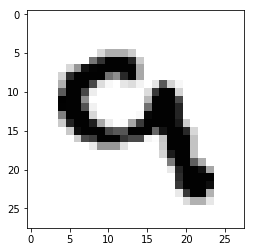

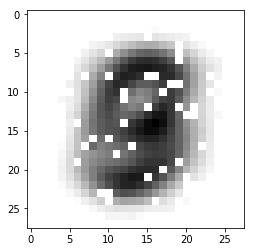

In [389]:
utils.display_reconstruction(autoencoder[0], mnist)

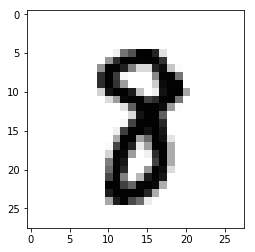

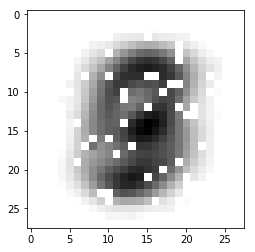

In [390]:
utils.display_reconstruction(autoencoder[0], mnist)

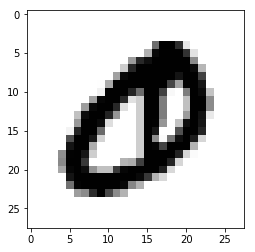

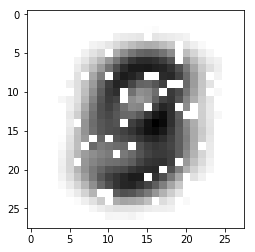

In [391]:
utils.display_reconstruction(autoencoder[0], mnist)

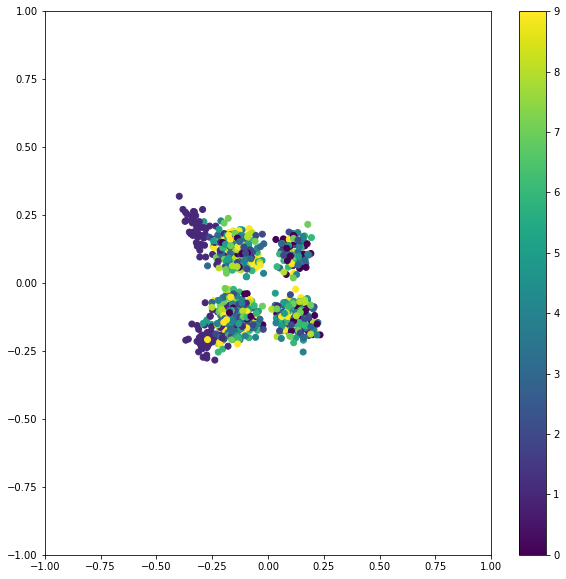

In [392]:
utils.display_encodings(autoencoder[0], mnist, [-1, 1])

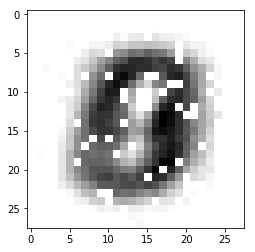

In [394]:
utils.display_decoding(autoencoder[0], mnist, torch.Tensor([1, 1]))

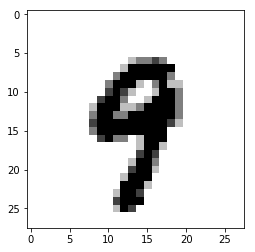

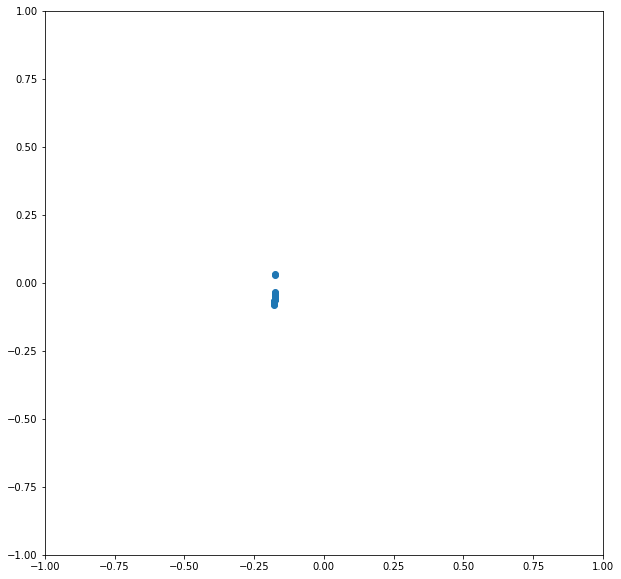

In [395]:
utils.display_encoding_variation(autoencoder[0], mnist, [-1, 1])

Well, we just ended up with a network that doesn't work at all.

Let's make a VAE that uses reparameterization then, and implement the ELBO loss function while we're at it.

In [267]:
class ReparameterizedVariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, emb_dim, noise_mag=0.01):
        super().__init__()
        assert emb_dim < input_dim
        
        self.encoder_tail = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 800),
            torch.nn.ReLU(),
            torch.nn.Linear(800, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
        )
        self.encoder_mean = torch.nn.Linear(100, emb_dim)
        self.encoder_std = torch.nn.Sequential(
            torch.nn.Linear(100, emb_dim),
            torch.nn.ReLU()
        )
        
        self.decoder_tail = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 800),
            torch.nn.ReLU(),
        )
        self.decoder_mean = torch.nn.Linear(800, input_dim)
        self.decoder_std = torch.nn.Sequential(
            torch.nn.Linear(800, input_dim),
            torch.nn.ReLU()
        )
        
        for param in self.parameters():
            if param.ndimension() >= 2:
                torch.nn.init.xavier_uniform(param)
            else:
                param.data.zero_()
                
        self.emb_dim = emb_dim
        
    def encode_dist(self, value):
        tail = self.encoder_tail(value)
        mean = self.encoder_mean(tail)
        std = self.encoder_std(tail) + 0.1
        return (mean, std)
    
    def sample(self, mean, std):
        sub_const = (mean.size()[1] / 2) * np.log(2 * np.pi)
        rands = torch.autograd.Variable(mean.data.clone().normal_())
        result = mean + rands * std
        log_probs_hidden = -(result ** 2).sum(dim=1) / 2 - sub_const
        log_probs_model = -(rands ** 2).sum(dim=1) / 2 - torch.log(std).sum(dim=1) - sub_const
        return (result, log_probs_hidden, log_probs_model)
    
    def encode(self, value):
        return self.sample(*self.encode_dist(value))[0]
    
    def decode_dist(self, value):
        tail = self.decoder_tail(value)
        mean = self.decoder_mean(tail)
        std = self.decoder_std(tail) + 0.1
        return (mean, std)
    
    def decode(self, value):
        return self.decode_dist(value)[0]
        
    def forward(self, value):
        (mean, cov) = self.encode_dist(value)
        (hidden, log_probs_hidden, log_probs_model) = self.sample(mean, cov)
        (mean, cov) = self.decode_dist(hidden)
        return (mean, cov, log_probs_hidden, log_probs_model)

In [275]:
class ELBOLossCriterion(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        
    def forward(self, vals, truth):
        (mean, std, log_probs_hidden, log_probs_model) = vals
        sub_const = (mean.size()[1] / 2) * np.log(2 * np.pi)
        truth_whitened = (truth - mean) / std
        log_probs_output = -(truth_whitened ** 2).sum(dim=1) / 2 - torch.log(std).sum(dim=1) - sub_const
        result = -(log_probs_output + log_probs_hidden - log_probs_model).mean()
        return result

In [276]:
mnist.labeled=False

In [285]:
autoencoder = [ReparameterizedVariationalAutoencoder(784, 2)]

In [286]:
utils.train(autoencoder, mnist, ELBOLossCriterion(2), 50, 1000, 0.002, 'reparameterized_variational_autoencoder')

Loaded checkpoint directly


In [287]:
mnist.labeled=True

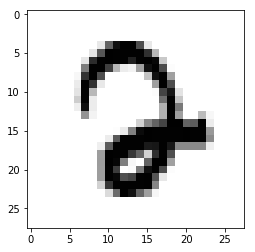

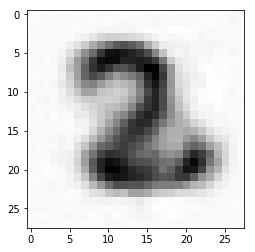

In [288]:
utils.display_reconstruction(autoencoder[0], mnist)

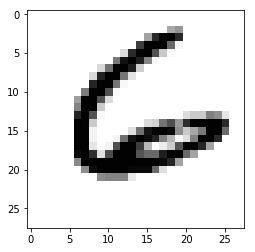

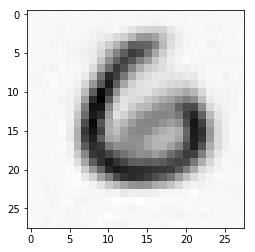

In [289]:
utils.display_reconstruction(autoencoder[0], mnist)

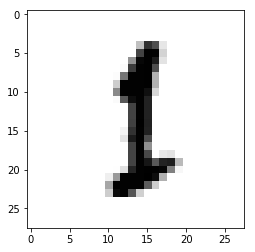

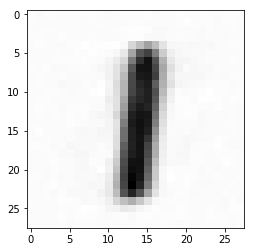

In [290]:
utils.display_reconstruction(autoencoder[0], mnist)

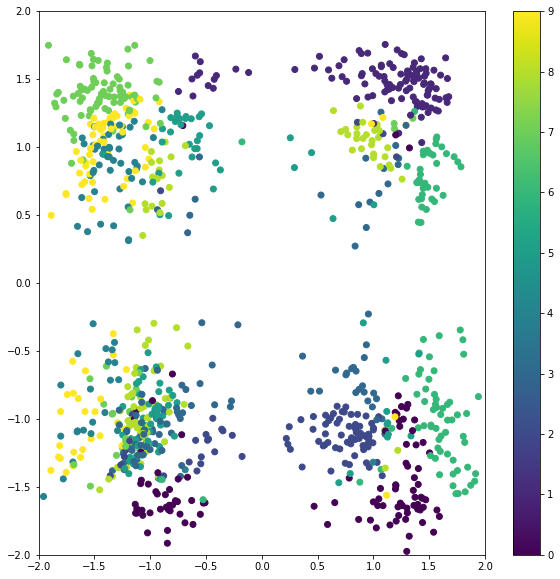

In [291]:
utils.display_encodings(autoencoder[0], mnist, [-2, 2])

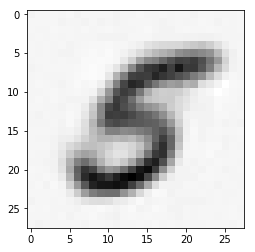

In [298]:
utils.display_decoding(autoencoder[0], mnist, torch.Tensor([-0.5, 0.9]))

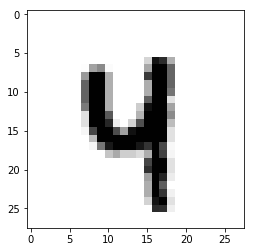

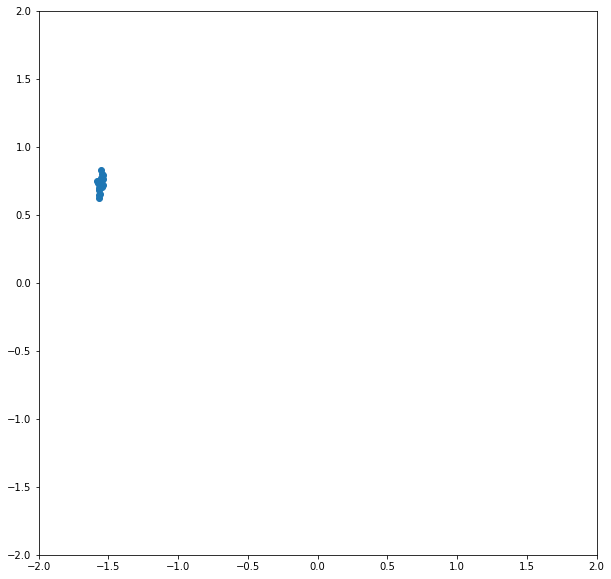

In [305]:
utils.display_encoding_variation(autoencoder[0], mnist, [-2, 2])

Results are pretty similar to the regular autoencoder. Plus, we can generate multiple outputs with the same latent vector.